Parametric non Parametric inference
===================

Suppose you have a physical model of an output variable, which takes the form of a parametric model. You now want to model the random effects of the data by a non-parametric (better: infinite parametric) model, such as a Gaussian Process as described in [BayesianLinearRegression](BayesianLinearRegression.ipynb). We can do inference in both worlds, the parameteric and infinite parametric one, by extending the features to a mix between 

\begin{align}
p(\mathbf{y}|\boldsymbol{\Phi}, \alpha, \sigma) &= \int p(\mathbf{y}|\boldsymbol{\Phi}, \mathbf{w}, \sigma)p(\mathbf{w}|\alpha) \,\mathrm{d}\mathbf{w}\\
&= \langle\mathcal{N}(\mathbf{y}|\boldsymbol{\Phi}\mathbf{w}, \sigma^2\mathbf{I})\rangle_{\mathcal{N}(\mathbf{0}, \alpha\mathbf{I})}\\
&= \mathcal{N}(\mathbf{y}|\mathbf{0}, \alpha\boldsymbol{\Phi}\boldsymbol{\Phi}^\top + \sigma^2\mathbf{I})
\end{align}

Thus, we can maximize this marginal likelihood w.r.t. the hyperparameters $\alpha, \sigma$ by log transforming and maximizing:

\begin{align}
\hat\alpha, \hat\sigma = \mathop{\arg\max}_{\alpha, \sigma}\log p(\mathbf{y}|\boldsymbol{\Phi}, \alpha, \sigma)
\end{align}

So we will define a mixed inference model mixing parametric and non-parametric models together. One part is described by a paramtric feature space mapping $\boldsymbol{\Phi}\mathbf{w}$ and the other part is a non-parametric function $\mathbf{f}_\text{n}$. For this we define the underlying function $\mathbf{f}$ as 

$$
\begin{align}
p(\mathbf{f}) &= p\left(
  \underbrace{
  \begin{bmatrix} 
   \delta(t-T)\\
   \boldsymbol{\Phi}
  \end{bmatrix}
  }_{=:\mathbf{A}}
  \left.
  \begin{bmatrix}
   \mathbf{f}_{\text{n}}\\
   \mathbf{w}
  \end{bmatrix}
  \right|
  \mathbf{0}, 
  \mathbf{A}
  \underbrace{
  \begin{bmatrix}
   \mathbf{K}_{\mathbf{f}} & \\
   & \mathbf{K}_{\mathbf{w}}
  \end{bmatrix}
  }_{=:\boldsymbol{\Sigma}}
  \mathbf{A}^\top
  \right)\enspace,
\end{align}
$$

where $\mathbf{K}_{\mathbf{f}}$ is the covariance describing the non-parametric part $\mathbf{f}_\text{n}\sim\mathcal{N}(\mathbf{0}, \mathbf{K}_\mathbf{f})$ and $\mathbf{K}_{\mathbf{w}}$ is the covariance of the prior over $\mathbf{w}\sim\mathcal{N}(\mathbf{w}|\mathbf{0}, \mathbf{K}_{\mathbf{w}})$.

Thus we can now predict the different parts and even the paramters $\mathbf{w}$ themselves using (Note: If someone is willing to write down the proper path to this, here a welcome and thank you very much. Thanks to Philipp Hennig for his ideas in this.)

$$
\begin{align}
p(\mathbf{f}|\mathbf{y}) &= 
 \mathcal{N}(\mathbf{f} | 
 \boldsymbol{\Sigma}\mathbf{A}^\top 
  \underbrace{
   (\mathbf{A}\boldsymbol{\Sigma}\mathbf{A}^\top + \sigma^2\mathbf{I})^{-1}}_{=:\mathbf{K}^{-1}}\mathbf{y}, \boldsymbol{\Sigma}-\boldsymbol{\Sigma}\mathbf{A}^\top\mathbf{K}^{-1}\mathbf{A}\boldsymbol{\Sigma})
 \\
p(\mathbf{w}|\mathbf{y}) &= \mathcal{N}(\mathbf{w} | \mathbf{K}_\mathbf{w}\boldsymbol{\Phi}^\top\mathbf{K}^{-1}\mathbf{y},
\mathbf{K}_{\mathbf{w}}-\mathbf{K}_{\mathbf{w}}\boldsymbol{\Phi}^\top\mathbf{K}^{-1}\boldsymbol{\Phi}\mathbf{K}_{\mathbf{w}}))
 \\
p(\mathbf{f}_\text{n}|\mathbf{y}) &= \mathcal{N}(\mathbf{f}_\text{n}| \mathbf{K}_\mathbf{f}\mathbf{K}^{-1}\mathbf{y},
\mathbf{K}_{\mathbf{f}}-\mathbf{K}_{\mathbf{f}}\mathbf{K}^{-1}\mathbf{K}_{\mathbf{f}}))
\end{align}
$$

In [1]:
import GPy, numpy as np, pandas as pd
from GPy.kern import LinearSlopeBasisFuncKernel, DomainKernel
%matplotlib inline

We will create some data with a non-linear function, strongly driven by two piecewise linear trends:

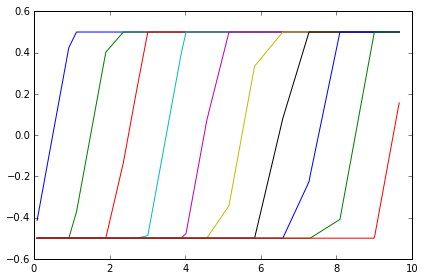

In [65]:
x = np.random.uniform(0, 10, 40)[:,None]
x.sort(0)
k_lin = LinearSlopeBasisFuncKernel(1, np.arange(0, 10), np.arange(1, 11), variance=1., ARD=1)
Phi = k_lin.phi(x)
_ = plt.plot(x, Phi)

We will assume the prior over $w_i\sim\mathcal{N}(0, 3)$ and a Matern32 structure in the non-parametric part. Additionally, we add a half parametric part, which is a periodic effect only active between $x\in[3,8]$:

In [146]:
k = GPy.kern.Matern32(1, .4)
Kf = k.K(x)

k_per = GPy.kern.PeriodicMatern32(1, variance=200, period=1)
k_per.period.fix()
k_dom = DomainKernel(1, 1, 5)
k_perdom = k_per * k_dom
Kpd = k_perdom.K(x)

In [147]:
np.random.seed(1234)
alpha = np.random.gamma(3, 1, Phi.shape[1])
w = np.random.normal(0, alpha)[:,None]

f_SE = np.random.multivariate_normal(np.zeros(x.shape[0]), Kf)[:, None]
f_perdom = np.random.multivariate_normal(np.zeros(x.shape[0]), Kpd)[:, None]
f_w = Phi.dot(w)

f = f_SE + f_w + f_perdom

y = f + np.random.normal(0, .1, f.shape)

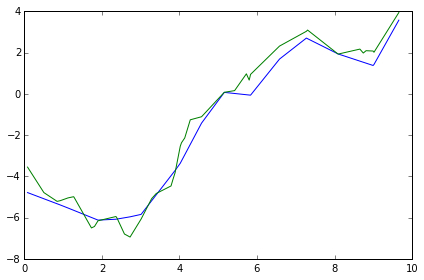

In [148]:
plt.plot(x, f_w)
_ = plt.plot(x, y)
# Make sure the function is driven by the linear trend, as there can be a difficulty in identifiability.

With this data, we can fit a model using the basis functions as paramtric part. If you want to implement your own basis function kernel, see GPy.kern._src.basis_funcs.BasisFuncKernel and implement the necessary parts. Usually it is enough to implement the phi(X) method, returning the higher dimensional mapping of inputs X.

In [149]:
k = (GPy.kern.Bias(1) 
     + GPy.kern.Matern52(1) 
     + LinearSlopeBasisFuncKernel(1, ARD=1, start=np.arange(0, 10), stop=np.arange(1, 11), name='linear_slopes')
     + k_perdom.copy()
     )

k.randomize()
m = GPy.models.GPRegression(x, y, k)

In [150]:
m.checkgrad(1)

                            Name                             |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------------------------------------
 GP_regression.add.bias.variance[[0]]                        |   1.000000    |   0.000000    |   0.126106    |   0.126106    |     4e-09     
 GP_regression.add.Mat52.variance[[0]]                       |   1.000000    |   0.000000    |   -1.234576   |   -1.234576   |     4e-08     
 GP_regression.add.Mat52.lengthscale[[0]]                    |   1.000000    |   0.000000    |   -2.290177   |   -2.290177   |     7e-08     
 GP_regression.add.linear_slopes.variance[[0]]               |   1.000000    |   0.000000    |   0.028064    |   0.028064    |     9e-10     
 GP_regression.add.linear_slopes.variance[[1]]               |   1.000000    |   0.000000    |   0.107821    |   0.107821    |     3e-09     
 GP_re

True

In [151]:
m.optimize()

{'dataplot': [<matplotlib.lines.Line2D at 0xd8b2b90>],
 'gpplot': [[<matplotlib.lines.Line2D at 0xd8b0750>],
  [<matplotlib.lines.Line2D at 0xd8b2550>]]}

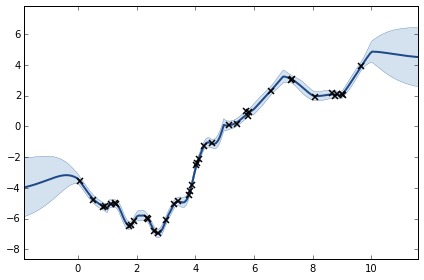

In [152]:
m.plot()

In [154]:
x_pred = np.linspace(0, 10, 500)[:,None]
pred_SE, var_SE = m._raw_predict(x_pred, kern=m.kern.Mat52)
pred_per, var_per = m._raw_predict(x_pred, kern=m.kern.mul)
pred_bias, var_bias = m._raw_predict(x_pred, kern=m.kern.bias)
pred_lin, var_lin = m._raw_predict(x_pred, kern=m.kern.linear_slopes)

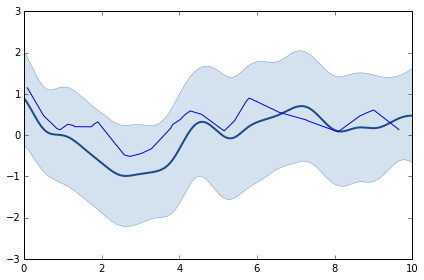

In [155]:
def gpplot(x, mu, var, ax=None):
    return GPy.plotting.matplot_dep.base_plots.gpplot(x, mu, mu+2*np.sqrt(var), mu-2*np.sqrt(var), ax=ax)
gpplot(x_pred, pred_SE, var_SE)
plt.plot(x, f_SE)

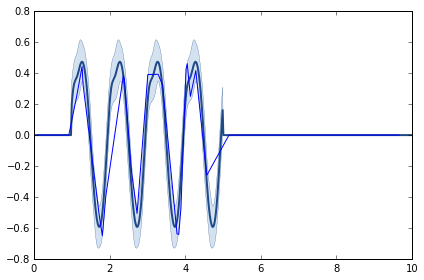

In [156]:
gpplot(x_pred, pred_per, var_per)
#plt.plot(x_pred, pred_Br)
plt.plot(x, f_perdom)

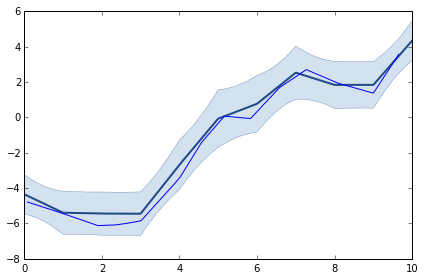

In [157]:
gpplot(x_pred, pred_lin, var_lin)
#plt.plot(x_pred, pred_Br)
plt.plot(x, f_w)

In [158]:
w_pred, w_var = m.kern.linear_slopes.posterior_inf()

In [159]:
df = pd.DataFrame(w, columns=['truth'], index=np.arange(0,10))
df['mean'] = w_pred
df['std'] = np.sqrt(w_var.diagonal())

In [160]:
df

,truth,mean,std
0,-0.711892,-1.047929,0.616952
1,-0.758501,-0.048109,0.212485
2,0.320025,-0.006444,0.171852
3,2.431582,2.766472,0.664038
4,3.548966,2.613057,0.750916
5,-0.199497,0.839531,0.674216
6,3.071090,1.761893,0.833464
7,-0.982112,-0.692073,0.656855
8,-0.619837,0.001764,0.186037
9,3.353923,2.501969,0.705696
